In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lfwpeople/pairsDevTrain.txt
/kaggle/input/lfwpeople/lfw-funneled.tgz
/kaggle/input/lfwpeople/pairsDevTest.txt
/kaggle/input/lfwpeople/pairs.txt


In [30]:
import os
import torch
import shutil
import matplotlib.pyplot as plt
import numpy as np
import tarfile
import cv2
import torch.nn as nn
import torch.optim as optim

from transformers import ViTModel
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

### Extract data

In [3]:
file_path = '/kaggle/input/lfwpeople/lfw-funneled.tgz'
with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall()

In [4]:
main_files = os.listdir('lfw_funneled')

In [5]:
len(main_files)
c = 0
for file_ in main_files:
    try:
        file_dir = os.path.join('lfw_funneled', file_)
        if len(os.listdir(file_dir)) == 1:
            c+=1
    except:
        pass

print(c)

4069


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vits16')
model = ViTModel.from_pretrained('facebook/dino-vits16').to(device)

Using device: cuda


preprocessor_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

### Face extraction

In [8]:
def extractFace(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30))

    if len(faces) > 0:
        (x, y, w, h) = faces[0]

        margin_x = int(w * 0.2)
        margin_y = int(h * 0.2)
        x = max(0, x - margin_x)
        y = max(0, y - margin_y)
        w = min(image.shape[1] - x, w + 2 * margin_x)
        h = min(image.shape[0] - y, h + 2 * margin_y)

        face = image[y:y+h, x:x+w]
        return cv2.cvtColor(face, cv2.COLOR_BGR2RGB)

    return None

### Prepare dataset

In [9]:
def prepareData(dataset_path="lfw_funneled", output_path="organized_lfw"):
    os.makedirs(output_path, exist_ok=True)

    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_path, split), exist_ok=True)

    for person_name in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person_name)
        if os.path.isdir(person_path):
            images = [img for img in os.listdir(person_path) if img.endswith('.jpg')]

            if len(images) == 1:
                dest = os.path.join(output_path, 'train', person_name)
                os.makedirs(dest, exist_ok=True)
                shutil.copy(os.path.join(person_path, images[0]), dest)
            elif len(images) == 2:
                dest_train = os.path.join(output_path, 'train', person_name)
                dest_test = os.path.join(output_path, 'test', person_name)
                os.makedirs(dest_train, exist_ok=True)
                os.makedirs(dest_test, exist_ok=True)
                shutil.copy(os.path.join(person_path, images[0]), dest_train)
                shutil.copy(os.path.join(person_path, images[1]), dest_test)
            else:
                train, test_val = train_test_split(images, test_size=0.4, random_state=42)
                val, test = train_test_split(test_val, test_size=0.5, random_state=42)

                for split_name, imgs in [('train', train), ('val', val), ('test', test)]:
                    dest = os.path.join(output_path, split_name, person_name)
                    os.makedirs(dest, exist_ok=True)
                    for img in imgs:
                        shutil.copy(os.path.join(person_path, img), dest)

prepareData()

### Face dataset class

In [12]:
class FaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.dataset = ImageFolder(root_dir)
        self.class_to_idx = self.dataset.class_to_idx
        self.samples = self.dataset.samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        face = extractFace(img_path)
        if face is None:
            image = Image.open(img_path).convert('RGB')
        else:
            image = Image.fromarray(face)

        if self.transform:
            image = self.transform(image)

        return image, label, img_path

### Fine-Tuning feature extractor (DINO) + Preprocessing

In [31]:
def get_class_weights(dataset_path):
    classes = os.listdir(dataset_path)
    labels = []
    for person_name in classes:
        person_path = os.path.join(dataset_path, person_name)
        labels.extend([classes.index(person_name)] * len(os.listdir(person_path)))
    
    weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    return torch.tensor(weights, dtype=torch.float).to(device)

In [51]:
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [52]:
def fine_tune_model(model):
    num_classes = len(os.listdir('organized_lfw/train'))
    
    model.dropout = nn.Dropout(0.5)
    model.classifier = nn.Sequential(
        nn.Linear(model.config.hidden_size, 128),  # Уменьшили размер скрытого слоя
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, num_classes)
    ).to(device)

    train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    train_dataset = FaceDataset('organized_lfw/train', train_transform)
    val_dataset = FaceDataset('organized_lfw/val', val_transform)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    class_weights = get_class_weights('organized_lfw/train')
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    
    best_val_loss = float('inf')
    patience = 3
    patience_counter = 0
    
    for epoch in range(10):
        model.train()
        train_loss = 0.0
        
        for images, labels, _ in tqdm(train_loader, desc=f'Train Epoch {epoch+1}'):
            images, labels = images.to(device), labels.to(device)
            
            # MixUp аугментация
            inputs, targets_a, targets_b, lam = mixup_data(images, labels)
            
            optimizer.zero_grad()
            outputs = model(inputs).last_hidden_state[:, 0]
            outputs = model.classifier(outputs)
            
            loss = lam * criterion(outputs, targets_a) + (1-lam) * criterion(outputs, targets_b)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels, _ in tqdm(val_loader, desc='Validating'):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).last_hidden_state[:, 0]
                outputs = model.classifier(outputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        
        print(f'\nEpoch {epoch+1}:')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}')
        print(f'Val Acc: {val_acc:.2f}%')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break
        
        scheduler.step(avg_val_loss)
    
    model.load_state_dict(torch.load('best_model.pth'))
    return model

In [45]:
def findSimilarFaces(query_image_path, model, top_k=5):
    face = extractFace(query_image_path)
    if face is None:
        query_image = Image.open(query_image_path).convert('RGB')
    else:
        query_image = Image.fromarray(face)

    query_tensor = test_transform(query_image).unsqueeze(0).to(device)
    with torch.no_grad():
        query_embedding = model(query_tensor).last_hidden_state[:, 0].cpu().numpy()

    similarities = cosine_similarity(query_embedding, test_embeddings)[0]

    top_k_indices = np.argsort(similarities)[-top_k:][::-1]
    results = [(test_paths[i], similarities[i]) for i in top_k_indices]

    return results

In [46]:
def results(query_image_path, similar_faces):
    try:
        query_image = Image.open(query_image_path)
    except:
        print("Could not open query image")
        return

    plt.figure(figsize=(15, 5))

    plt.subplot(1, len(similar_faces) + 1, 1)
    plt.title("Query Image")
    plt.imshow(query_image)
    plt.axis("off")

    for i, (path, similarity) in enumerate(similar_faces):
        try:
            img = Image.open(path)
            plt.subplot(1, len(similar_faces) + 1, i + 2)
            plt.title(f"Similarity: {similarity}")
            plt.imshow(img)
            plt.axis("off")
        except:
            continue

    plt.tight_layout()
    plt.show()

### Similarity based image retrieval (K-nearest)

In [47]:
def extractEmbeddings(model, dataloader):
    model.eval()
    embeddings = []
    paths = []
    labels = []

    with torch.no_grad():
        for images, lbls, img_paths in tqdm(dataloader, desc='Extracting embeddings', leave=False):
            images = images.to(device)
            outputs = model(images).last_hidden_state[:, 0]
            embeddings.append(outputs.cpu().numpy())
            paths.extend(img_paths)
            labels.extend(lbls.cpu().numpy())

    return np.concatenate(embeddings), np.array(labels), paths

In [48]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = FaceDataset('organized_lfw/test', test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [49]:
test_embeddings, test_labels, test_paths = extractEmbeddings(model, test_loader)

Extracting embeddings:   0%|          | 0/82 [00:00<?, ?it/s]

In [53]:
model = fine_tune_model(model)

Train Epoch 1:   0%|          | 0/281 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 1:
Train Loss: 8.6827
Val Loss: 8.6604
Val Acc: 0.00%


Train Epoch 2:   0%|          | 0/281 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 2:
Train Loss: 8.5605
Val Loss: 8.8879
Val Acc: 0.00%


Train Epoch 3:   0%|          | 0/281 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ecf4b002170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ecf4b002170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


Epoch 3:
Train Loss: 8.3769
Val Loss: 8.8124
Val Acc: 0.00%


Train Epoch 4:   0%|          | 0/281 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 4:
Train Loss: 8.2852
Val Loss: 8.8701
Val Acc: 0.00%
Early stopping triggered!


<ipython-input-52-4269170156bc>:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Query image: organized_lfw/test/Hassan_Wirajuda/Hassan_Wirajuda_0002.jpg


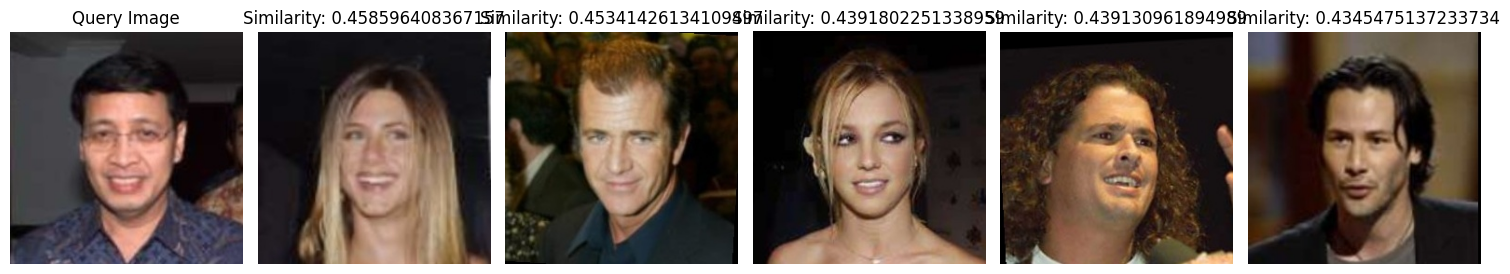

In [57]:
query_idx = np.random.choice(len(test_paths))
query_image_path = test_paths[query_idx]
print(f"\nQuery image: {query_image_path}")

similar_faces = findSimilarFaces(query_image_path, model)
results(query_image_path, similar_faces)